In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model


In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = 256

CHANNELS=3  
EPOCHS=60


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "citrus and beans",
    shuffle=True,
    
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 735 files belonging to 9 classes.


potato_early_blight = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato_Early_blight"

potato_lately_blight = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato___Late_blight"

potato_healthy = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato___healthy"

In [5]:
class_names = dataset.class_names

class_names

['Citrus  Canker',
 'Citrus  Greening',
 'Citrus  Healthy',
 'Citrus  Melanose',
 'Citrus Black spot',
 'Citrus Leaf Disease Image',
 'bean angular_leaf_spot',
 'bean healthy',
 'bean_rust']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())  #batch size 32 256 image size 

(16, 256, 256, 3)
[0 4 1 4 1 4 0 1 4 6 0 1 1 0 0 4]


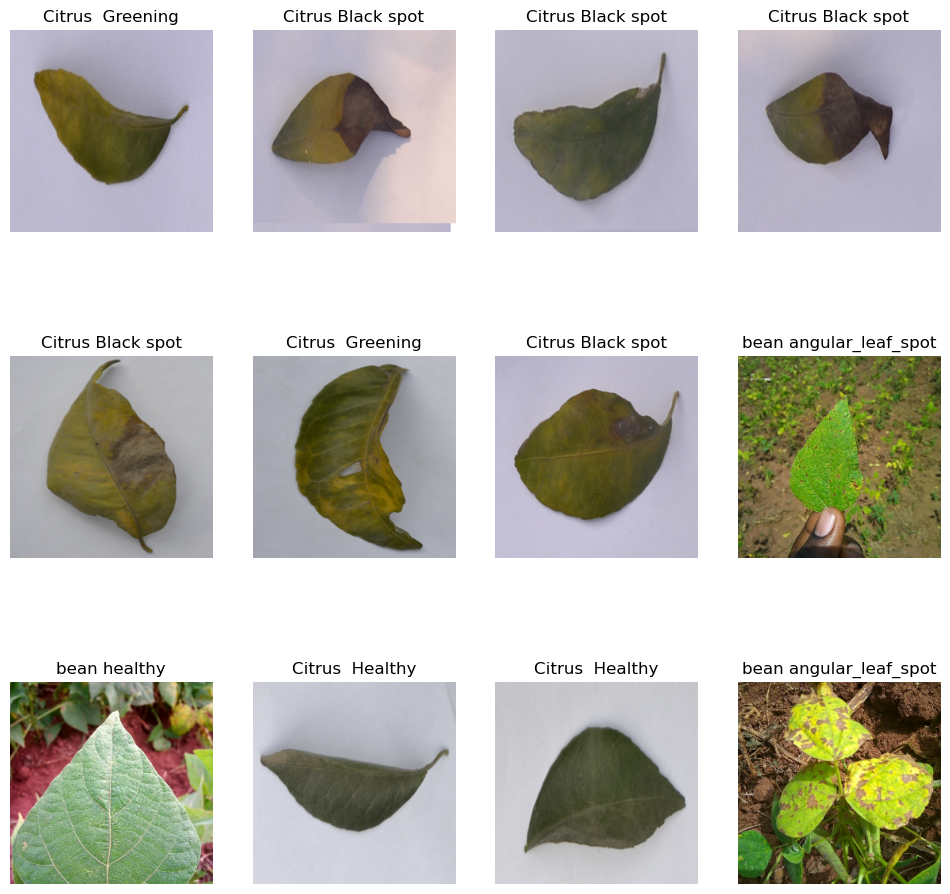

In [7]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):  
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1) #plot
        plt.imshow(image_batch[i].numpy().astype("uint8"))  #random
        plt.title(class_names[labels_batch[i]]) 
        plt.axis("off")

# SPLITTING

80% ==>training 20% ==>10% for testing other 10% for validating

In [8]:
len(dataset)    #total images/batch size


46

In [9]:
train_size = 0.8                #580*.8  for training


In [10]:
len(dataset)*train_size


36.800000000000004

In [11]:
train_ds = dataset.take(36)     


In [12]:
len(train_ds)

36

In [13]:
test_ds = dataset.skip(36)


In [14]:
len(test_ds)

10

In [15]:
val_size=0.1


In [16]:
len(dataset)*val_size

4.6000000000000005

In [17]:
val_ds = test_ds.take(4)


In [18]:
len(val_ds)

4

In [19]:
test_ds = test_ds.skip(4)


In [20]:
len(test_ds)

6

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=20000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

36

In [24]:
len(val_ds)

4

In [25]:
len(test_ds)

6

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# Getting images into same size

In [27]:
resize_and_rescale = tf.keras.Sequential([
    
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
    
])


Changing the image style


In [28]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


BUILDING THE MODEL


In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [30]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9


In [31]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [32]:
model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=80,
)

Epoch 1/80
 3/36 [=>............................] - ETA: 1:05 - loss: 2.1889 - accuracy: 0.2292

In [65]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 3s 302ms/step - loss: 0.4337 - accuracy: 0.8542


In [66]:
scores

[0.433697909116745, 0.8541666865348816]

In [67]:
history

In [68]:
history.params

{'verbose': 1, 'epochs': 60, 'steps': 36}

In [69]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [70]:
type(history.history['loss'])

list

In [71]:
len(history.history['loss'])

60

In [72]:
history.history['loss'][:5] 

[1.8598504066467285,
 1.4570926427841187,
 1.2417632341384888,
 1.2261161804199219,
 1.0702204704284668]

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(val_acc)

[0.34375, 0.390625, 0.46875, 0.40625, 0.484375, 0.46875, 0.421875, 0.5, 0.609375, 0.578125, 0.46875, 0.546875, 0.53125, 0.375, 0.671875, 0.640625, 0.625, 0.609375, 0.609375, 0.609375, 0.71875, 0.6875, 0.65625, 0.65625, 0.734375, 0.71875, 0.71875, 0.703125, 0.734375, 0.765625, 0.78125, 0.765625, 0.765625, 0.796875, 0.6875, 0.875, 0.8125, 0.796875, 0.8125, 0.84375, 0.828125, 0.765625, 0.828125, 0.75, 0.828125, 0.84375, 0.796875, 0.890625, 0.859375, 0.84375, 0.8125, 0.796875, 0.796875, 0.890625, 0.78125, 0.875, 0.875, 0.796875, 0.84375, 0.8125]


In [74]:
loss = history.history['loss']
val_loss = history.history['val_loss']

print(val_loss)

[1.5776420831680298, 1.2138676643371582, 1.1199219226837158, 1.1775568723678589, 1.1986384391784668, 1.0155519247055054, 0.9706360697746277, 1.0147963762283325, 0.8912711143493652, 0.8468841314315796, 0.8771920204162598, 0.8479679226875305, 0.9941231608390808, 1.3286439180374146, 0.7177858352661133, 0.8073136210441589, 0.8781444430351257, 0.7552662491798401, 0.8464430570602417, 0.7917280197143555, 0.6782330870628357, 0.6799190044403076, 0.8540105819702148, 0.7771596312522888, 0.6295343637466431, 0.7056291103363037, 0.6333920955657959, 0.7349421977996826, 0.5721679925918579, 0.5891273021697998, 0.44169527292251587, 0.5891985893249512, 0.7544395923614502, 0.574524998664856, 0.9462655782699585, 0.48938658833503723, 0.5728854537010193, 0.5038561820983887, 0.6409644484519958, 0.4729772210121155, 0.5151562690734863, 0.7576254606246948, 0.5335689187049866, 0.711538553237915, 0.795458197593689, 0.5330346822738647, 0.6668304204940796, 0.40512046217918396, 0.43795982003211975, 0.4454002678394317

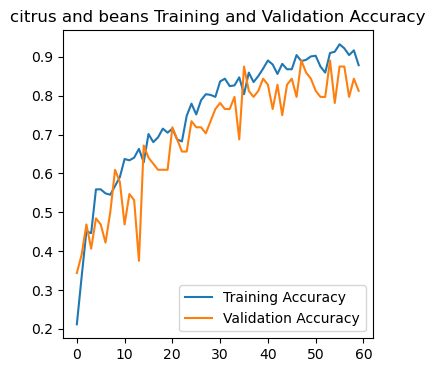

In [75]:
plt.figure(figsize=(4, 4))

plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('citrus and beans Training and Validation Accuracy')


plt.show()

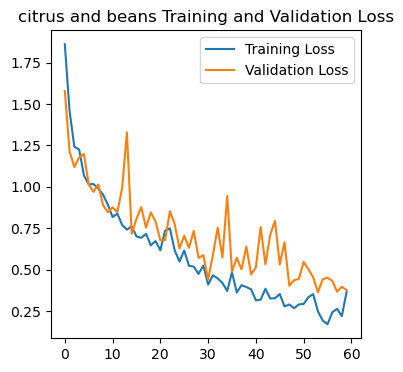

In [76]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('citrus and beans Training and Validation Loss')

plt.show()

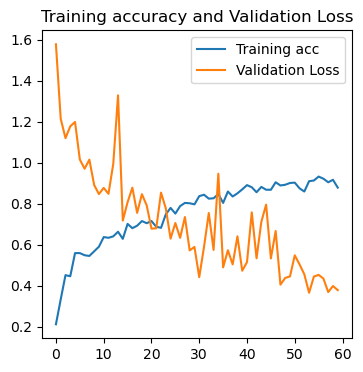

In [77]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), acc, label='Training acc')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training accuracy and Validation Loss')

plt.show()

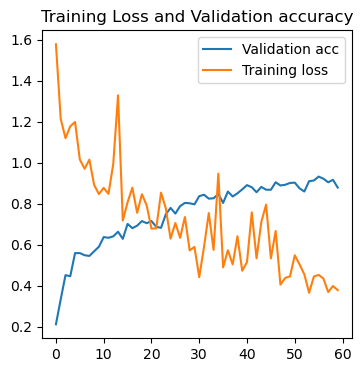

In [78]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), acc, label='Validation acc')
plt.plot(range(EPOCHS), val_loss, label='Training loss')
plt.legend(loc='upper right')
plt.title('Training Loss and Validation accuracy')

plt.show()

first image to predict
actual label: Citrus  Greening
1/1 [==============================] - 0s 404ms/step
predicted label: Citrus  Greening


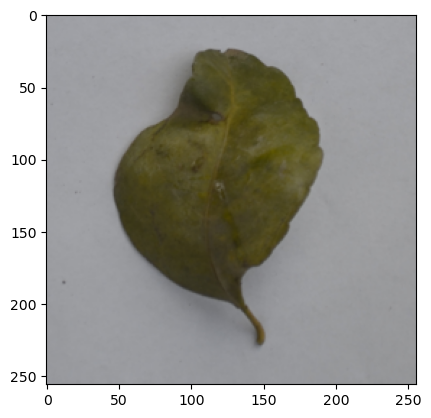

In [79]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [80]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


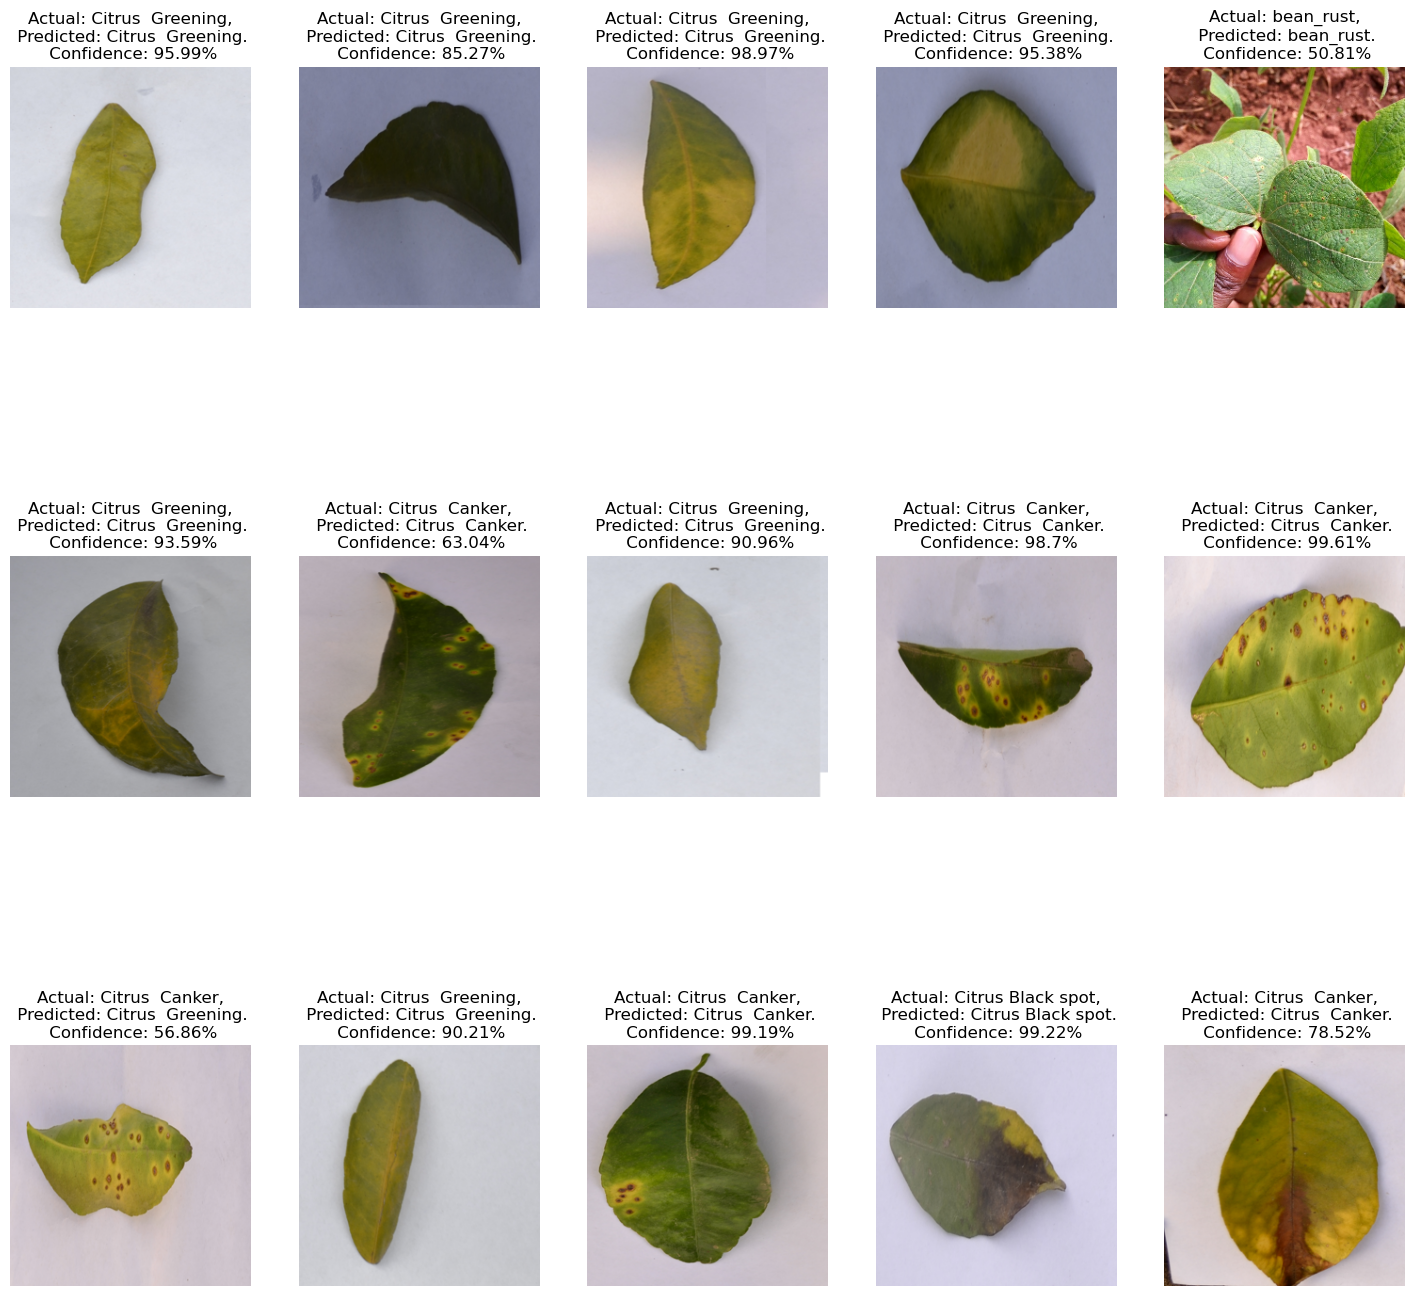

In [81]:
plt.figure(figsize=(18, 18))
for images, labels in test_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [82]:
import os
os.listdir("../citrusandbeansmodel")

['3', '4']

In [83]:
import os
model_version=max([int(i) for i in os.listdir("../citrusandbeansmodel") + [0]])+1
model.save(f"../citrusandbeansmodel/{model_version}")

INFO:tensorflow:Assets written to: ../citrusandbeansmodel/5\assets


INFO:tensorflow:Assets written to: ../citrusandbeansmodel/5\assets


In [84]:
model.save("../citrusandbeans.h5")